Author: Maha Alali

# Heat Maps Per Bedroom Difference

Using the gained/decreased/no change bedroom data, we can create a heat map to visualize the amount of bedrooms lost and gained based on if bedrooms_diff is postive or negative based on neighborhood.

Steps:
- 1- Make a new dataset including the get the corresponding long and lat from the SAM dataset, for each PID.
- 2- Load the GeoJSON file to understand the structure of the neighborhood boundaries data.
- 3- Convert the new datasets to GeoDataFrames: This involves using the latitude and longitude columns to create a geometry column necessary for spatial operations.
- 4- Spatially join these GeoDataFrames with the neighborhoods GeoDataFrame: This step assigns each property to a neighborhood based on its geographic coordinates.
- 5- Aggregate the bedroom differences by neighborhood: We'll sum the bedrooms_diff column within each neighborhood to understand the total change in the number of bedrooms.
- 6- Create and diplay a map


Step 1: We map each PID in each, decreased_bedrooms_data, increased_bedrooms_data and
unchanged_bedrooms_data to PARCEL for each property by merging the columns in the dataset.

In [ ]:
import pandas as pd

increased_bedrooms_data = pd.read_csv('../Cleaned Bedroom Data/increased_bedrooms_data.csv')
decreased_bedrooms_data = pd.read_csv('../Cleaned Bedroom Data/decreased_bedrooms_data.csv')
unchanged_bedrooms_data = pd.read_csv('../Cleaned Bedroom Data/unchanged_bedrooms_data.csv')

sam_data = pd.read_csv('../data/Live_Street_Address_Management_(SAM)_Addresses.csv')[['PARCEL','X', 'Y']]

# Function to merge bedroom data with SAM data
def merge_with_sam(bedroom_data, sam_data):
    # Merge on 'PID' from bedroom_data and 'PARCEL' from sam_data
    merged_data = pd.merge(bedroom_data, sam_data, left_on='PID', right_on='PARCEL')

    # Dropping the 'PARCEL' column as 'PARCEL' and 'PID' are the same
    merged_data.drop(columns=['PARCEL'], inplace=True)

    # Rename 'X' to 'latitude' and 'Y' to 'longitude'
    merged_data.rename(columns={'X': 'latitude', 'Y': 'longitude'}, inplace=True)

    return merged_data

# Merge each DataFrame with SAM data
increased_bedrooms_merged = merge_with_sam(increased_bedrooms_data, sam_data)
decreased_bedrooms_merged = merge_with_sam(decreased_bedrooms_data, sam_data)
unchanged_bedrooms_merged = merge_with_sam(unchanged_bedrooms_data, sam_data)

# Dropping the duplicate rows since we might have multiple addressses that differ in unit but have the same PID when merging with sam dataset
increased_bedrooms_merged = increased_bedrooms_merged.drop_duplicates(subset=['PID'], keep='first')
decreased_bedrooms_merged = decreased_bedrooms_merged.drop_duplicates(subset=['PID'], keep='first')
unchanged_bedrooms_merged = unchanged_bedrooms_merged.drop_duplicates(subset=['PID'], keep='first')

# Optionally, save the merged DataFrames to CSV files
increased_bedrooms_merged.to_csv('increased_bedrooms_merged.csv', index=False)
decreased_bedrooms_merged.to_csv('decreased_bedrooms_merged.csv', index=False)
unchanged_bedrooms_merged.to_csv('unchanged_bedrooms_merged.csv', index=False)

display(increased_bedrooms_merged.head())

display(decreased_bedrooms_merged.head())

display(unchanged_bedrooms_merged.head())

/var/folders/d0/35z98j6s1_s8v_lhkt9b2wcw0000gn/T/ipykernel_6711/868903463.py:1: DtypeWarning: Columns (8,9,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  sam_data = pd.read_csv('../data/neighborhood_data/Live_Street_Address_Management_(SAM)_Addresses.csv')[['PARCEL','X', 'Y']]


,PID,DATA_YEAR,LIVING_AREA,YR_REMODELLED,BED_ROOMS,REMODEL_YEAR,living_area_diff,bedrooms_diff,latitude,longitude
0,100028000,2019,3275.0,2015.0,8.0,2015.0,899.0,2.0,-71.030521,42.379799
1,100035000,2020,2806.0,2018.0,5.0,2018.0,-14.0,2.0,-71.031011,42.379549
5,100058000,2018,3651.0,2015.0,11.0,2015.0,-189.0,3.0,-71.029429,42.378775
9,100105000,2018,3402.0,2016.0,8.0,2016.0,-275.0,2.0,-71.029101,42.379919
13,100262000,2018,2722.0,2011.0,10.0,2011.0,-158.0,2.0,-71.027161,42.381209


,PID,DATA_YEAR,LIVING_AREA,YR_REMODELLED,BED_ROOMS,REMODEL_YEAR,living_area_diff,bedrooms_diff,latitude,longitude
0,100163000,2019,1499.0,2017.0,3.0,2017.0,56.0,-1.0,-71.029291,42.380639
3,101893000,2018,4389.0,2015.0,7.0,2015.0,235.0,-2.0,-71.006001,42.389059
7,102531000,2020,2314.0,2018.0,4.0,2018.0,0.0,-2.0,-71.038951,42.376979
15,102743000,2022,1368.0,2019.0,3.0,2019.0,-72.0,-1.0,-71.037711,42.380415
16,102925000,2013,1596.0,2003.0,2.0,2017.0,0.0,-4.0,-71.036041,42.378099


,PID,DATA_YEAR,LIVING_AREA,YR_REMODELLED,BED_ROOMS,REMODEL_YEAR,living_area_diff,bedrooms_diff,latitude,longitude
0,100029000,2018,4475.0,2015.0,9.0,2015.0,18.0,0.0,-71.030461,42.379709
4,100104000,2022,3308.0,2020.0,8.0,2020.0,0.0,0.0,-71.029261,42.379849
8,100137000,2018,1197.0,2015.0,2.0,2015.0,0.0,0.0,-71.029031,42.379679
11,100139000,2018,2563.0,2013.0,4.0,2013.0,-39.0,0.0,-71.029021,42.379519
14,100145000,2018,0.0,2015.0,5.0,2015.0,-2694.0,0.0,-71.029521,42.379319


Step 2: Load the GeoJSON file to understand the structure of the neighborhood boundaries data.

In [ ]:
import geopandas as gpd

# Load the GeoJSON file
neighborhood_boundaries = gpd.read_file('../data/neighborhood_data/BPDA_Neighborhood_Boundaries.geojson')

# Display the first few rows to verify the structure
display(neighborhood_boundaries)

,sqmiles,name,neighborhood_id,acres,SHAPE__Length,objectid,SHAPE__Area,geometry
0,2.51,Roslindale,15,1605.568237,53563.912597,53,6.993827e+07,"MULTIPOLYGON (((-71.12593 42.27201, -71.12611 ..."
1,3.94,Jamaica Plain,11,2519.245394,56349.937161,54,1.097379e+08,"POLYGON ((-71.10499 42.32610, -71.10503 42.326..."
2,0.55,Mission Hill,13,350.853564,17918.724113,55,1.528312e+07,"POLYGON ((-71.09043 42.33577, -71.09050 42.335..."
3,0.29,Longwood,28,188.611947,11908.757148,56,8.215904e+06,"POLYGON ((-71.09811 42.33673, -71.09832 42.337..."
4,0.04,Bay Village,33,26.539839,4650.635493,57,1.156071e+06,"POLYGON ((-71.06663 42.34878, -71.06663 42.348..."
5,0.02,Leather District,27,15.639908,3237.140537,58,6.812717e+05,"POLYGON ((-71.05838 42.34983, -71.05834 42.349..."
6,0.12,Chinatown,26,76.324410,9736.590413,59,3.324678e+06,"POLYGON ((-71.05791 42.35238, -71.05811 42.352..."
7,0.20,North End,14,126.910439,16177.826815,60,5.527506e+06,"POLYGON ((-71.05200 42.36884, -71.05219 42.368..."
8,3.29,Roxbury,16,2108.469072,49488.800485,61,9.184455e+07,"POLYGON ((-71.09646 42.29323, -71.09633 42.293..."
9,0.74,South End,32,471.535356,17912.333569,62,2.054000e+07,"POLYGON ((-71.06834 42.34775, -71.06913 42.347..."


Step 3: Convert the new datasets to GeoDataFrames: This involves using the latitude and longitude columns to create a geometry column necessary for spatial operations.

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# Concatenate the datasets as shown in the previous response
all_bedrooms_data = pd.concat([increased_bedrooms_merged, decreased_bedrooms_merged, unchanged_bedrooms_merged])

# Create a GeoDataFrame
all_bedrooms_data['geometry'] = all_bedrooms_data.apply(lambda row: Point(row['latitude'], row['longitude']), axis=1)
all_bedrooms_geo = gpd.GeoDataFrame(all_bedrooms_data, geometry='geometry')


# Make sure the coordinate reference system (CRS) are same for both datasets
all_bedrooms_geo.crs = 'EPSG:4326'

print(all_bedrooms_geo.crs)
print(neighborhood_boundaries.crs)

EPSG:4326
EPSG:4326


Step 4: Spatially join these GeoDataFrames with the neighborhoods GeoDataFrame: This step assigns each property to a neighborhood based on its geographic coordinates.

In [ ]:
# Perform a spatial join to associate bedrooms with neighborhoods
bedrooms_with_neighborhoods = gpd.sjoin(all_bedrooms_geo, neighborhood_boundaries, how='inner', op='intersects')

# Filter the extra bedroom_diff_left column that was created bc of the sjoin
bedrooms_with_neighborhoods.rename(columns={'bedrooms_diff_left': 'bedrooms_diff'}, inplace=True)

# Drop the bedrooms_diff_y column
if  'bedrooms_diff_x' in bedrooms_with_neighborhoods.columns:
    bedrooms_with_neighborhoods.drop(columns=['bedrooms_diff_x'], inplace=True)
if 'bedrooms_diff_y' in bedrooms_with_neighborhoods.columns:
    bedrooms_with_neighborhoods.drop(columns=['bedrooms_diff_y'], inplace=True)
if 'bedrooms_diff_right' in bedrooms_with_neighborhoods.columns:
    bedrooms_with_neighborhoods.drop(columns=['bedrooms_diff_right'], inplace=True)



# Now joined_df contains properties along with their respective neighborhood information

/Users/maha/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


5- Aggregate the bedroom differences by neighborhood

In [ ]:
# Drop row bedrooms_diff so that there is no overlap when merging
if 'bedroom_diff' in neighborhood_boundaries.columns:
    neighborhood_boundaries.drop(columns=['bedrooms_diff'], inplace=True)


neighborhood_boundaries = neighborhood_boundaries.merge(total_bedrooms_change_by_neighborhood, on='name', how='left')

display(neighborhood_boundaries.head())


,sqmiles,name,neighborhood_id,acres,SHAPE__Length,objectid,SHAPE__Area,geometry,bedrooms_diff_x,color,bedrooms_diff_y,bedrooms_diff
0,2.51,Roslindale,15,1605.568237,53563.912597,53,6.993827e+07,"MULTIPOLYGON (((-71.12593 42.27201, -71.12611 ...",12.0,green,12.0,12.0
1,3.94,Jamaica Plain,11,2519.245394,56349.937161,54,1.097379e+08,"POLYGON ((-71.10499 42.32610, -71.10503 42.326...",70.0,green,70.0,70.0
2,0.55,Mission Hill,13,350.853564,17918.724113,55,1.528312e+07,"POLYGON ((-71.09043 42.33577, -71.09050 42.335...",36.0,green,36.0,36.0
3,0.29,Longwood,28,188.611947,11908.757148,56,8.215904e+06,"POLYGON ((-71.09811 42.33673, -71.09832 42.337...",NaN,white,NaN,NaN
4,0.04,Bay Village,33,26.539839,4650.635493,57,1.156071e+06,"POLYGON ((-71.06663 42.34878, -71.06663 42.348...",0.0,white,0.0,0.0


Step 6: Create and diplay a map

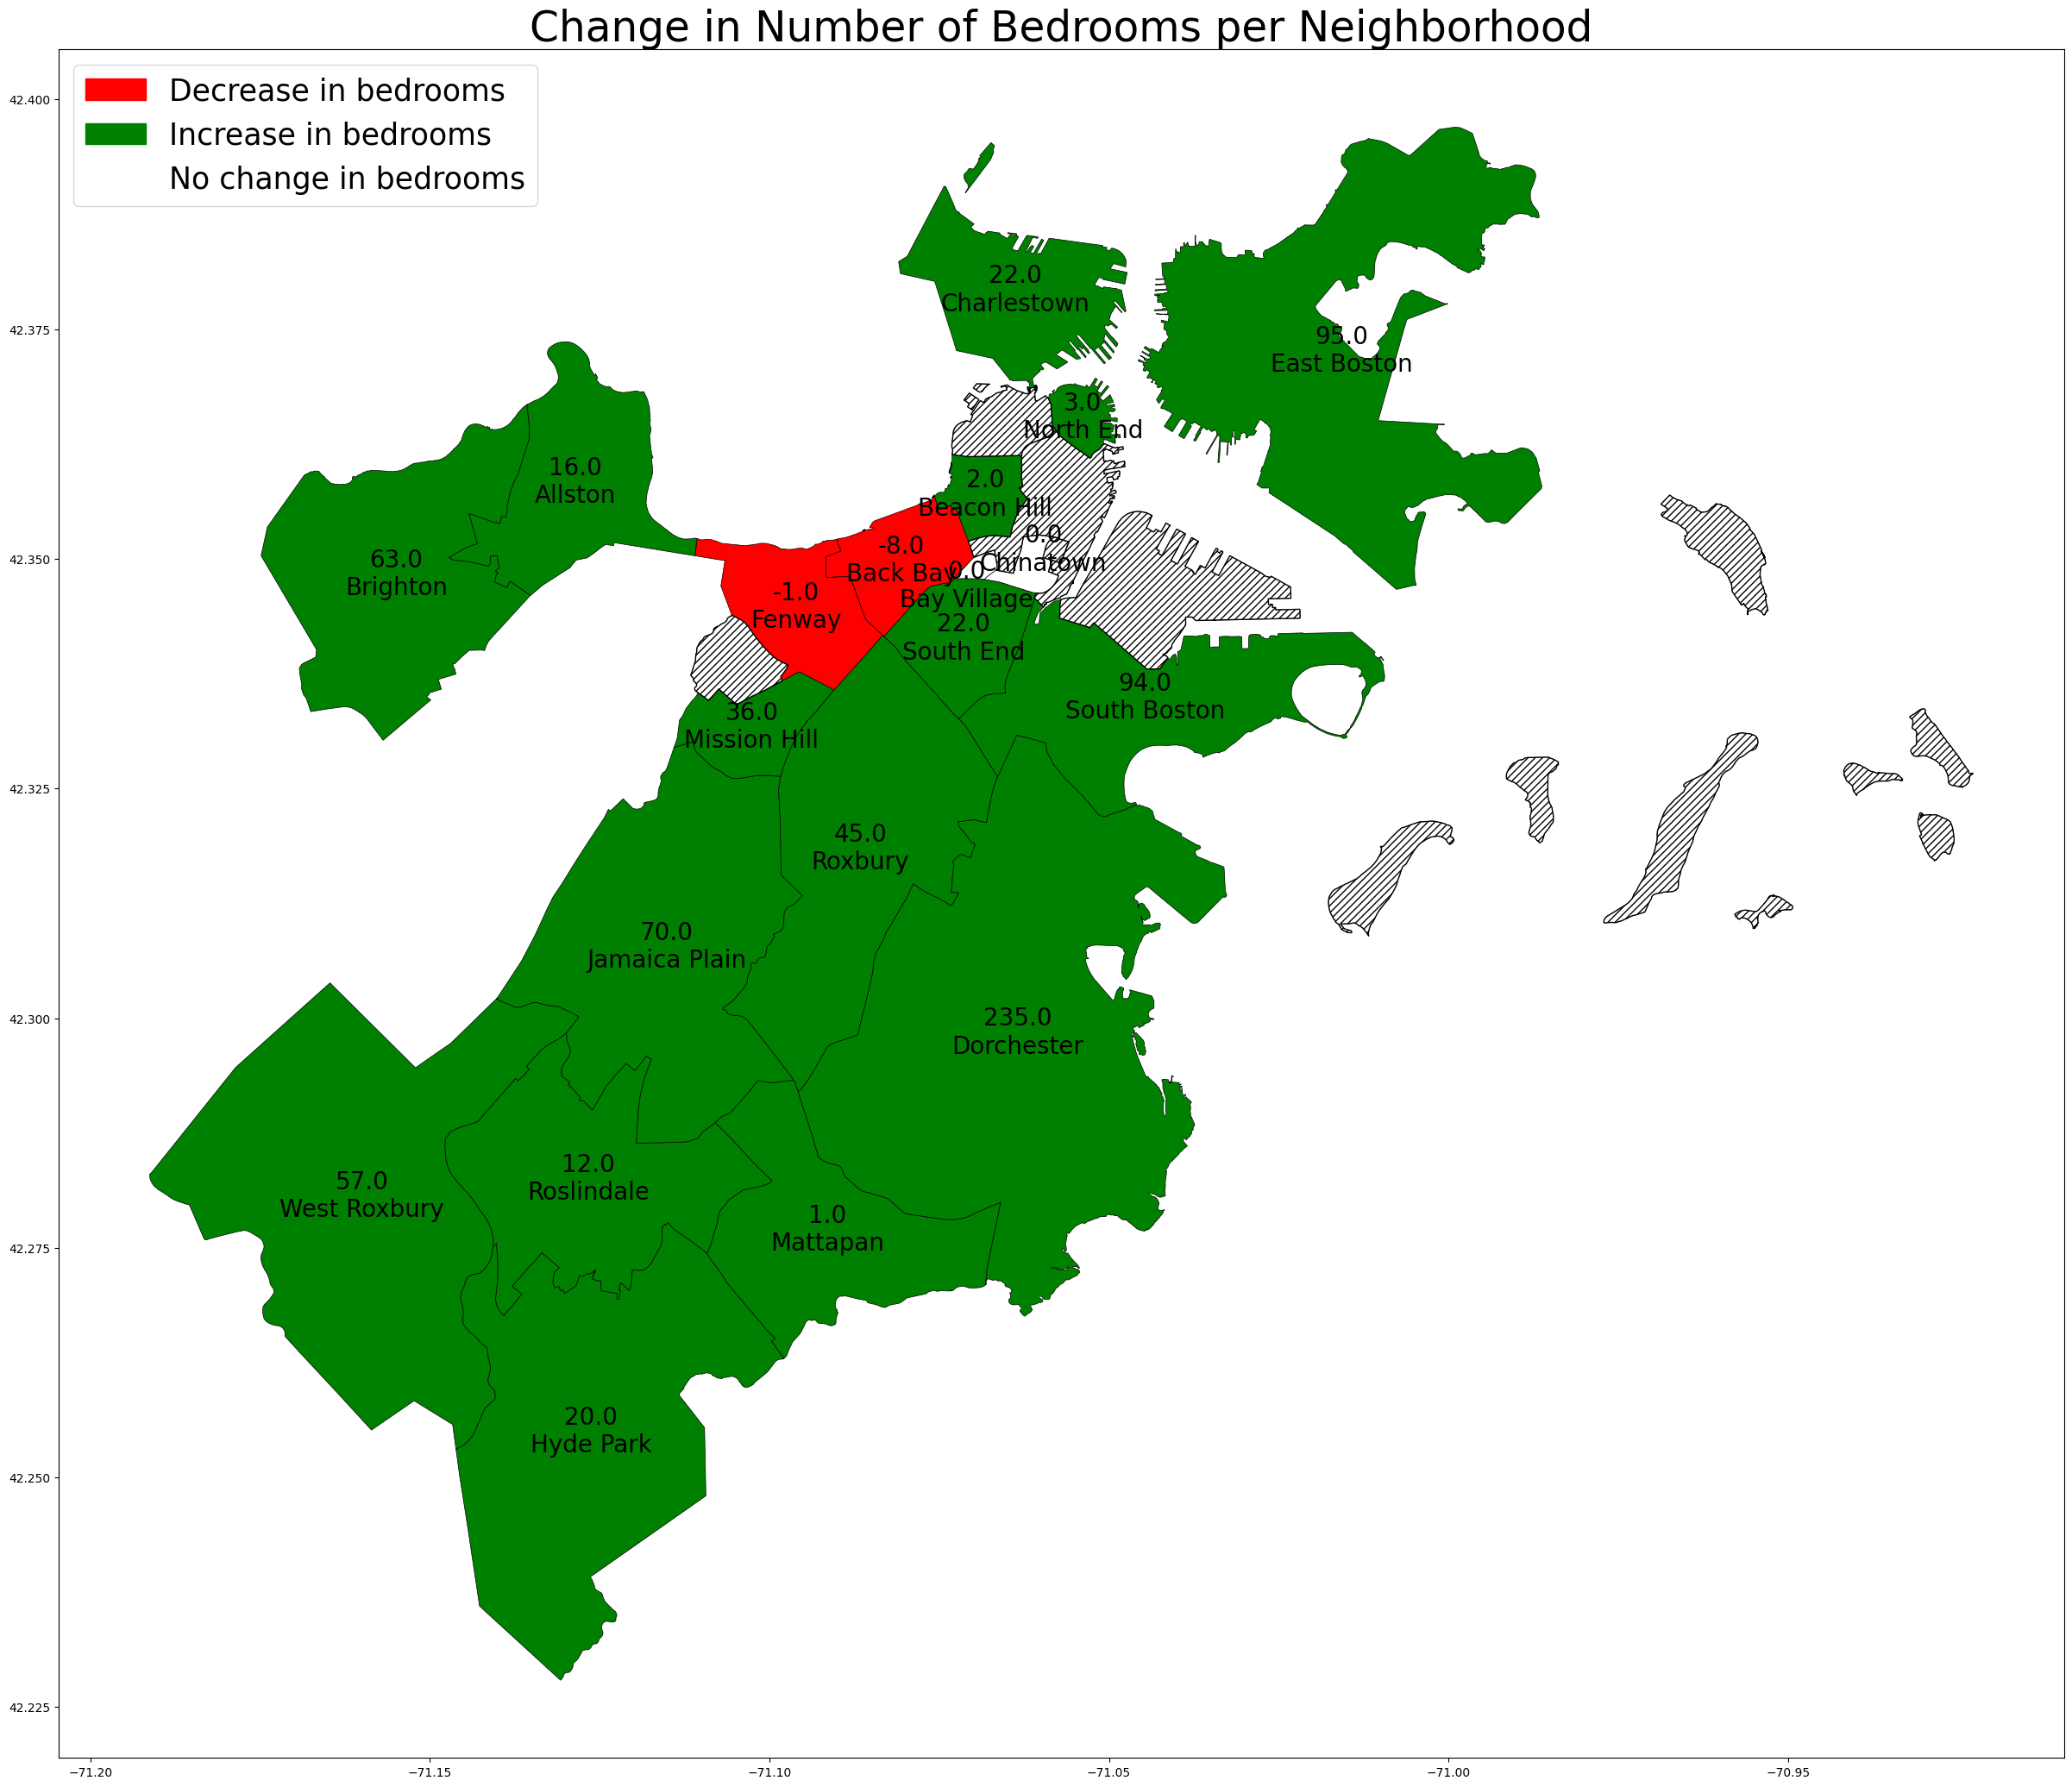

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

# Map bedroom_diff to colors: red for increase, green for decrease/no change
neighborhood_boundaries['color'] = neighborhood_boundaries['bedrooms_diff'].apply(lambda x: 'green' if x > 0 else 'red' if x<0 else 'white')


fig, ax = plt.subplots(1, figsize=(30, 30))

# Plot using custom colors for increase, decrease, and no changes
neighborhood_boundaries.plot(ax=ax, color=neighborhood_boundaries['color'], edgecolor='black', linewidth=0.5)

# Add lines for areas with missing data
missing_data_areas = neighborhood_boundaries[pd.isnull(neighborhood_boundaries['bedrooms_diff'])]
missing_data_areas.plot(ax=ax, color="white", hatch="////", edgecolor="black", linewidth=1)

# Custom legend
red_patch = mpatches.Patch(color='red', label='Decrease in bedrooms')
green_patch = mpatches.Patch(color='green', label='Increase in bedrooms')
white_patch = mpatches.Patch(color='white', label='No change in bedrooms')
plt.legend(handles=[red_patch, green_patch, white_patch], loc='upper left', fontsize=25)

# Annotations for bedroom change and neighborhood name
for idx, row in neighborhood_boundaries.iterrows():
    if pd.notnull(row['bedrooms_diff']):
        if row['name'] == 'Chinatown':
            # Adjust position for Chinatown label
            ax.annotate(f"{row['bedrooms_diff']}\n{row['name']}", 
                        xy=(row['geometry'].centroid.x+ 0.002, row['geometry'].centroid.y + 0.002),  # Adjust Y position
                        horizontalalignment='center', verticalalignment='center',
                        fontsize=20, color='black')
        elif row['name'] == 'Bay Village':
            # Adjust position for Chinatown label
            ax.annotate(f"{row['bedrooms_diff']}\n{row['name']}", 
                        xy=(row['geometry'].centroid.x - 0.002, row['geometry'].centroid.y - 0.002),  # Adjust Y position
                        horizontalalignment='center', verticalalignment='center',
                        fontsize=20, color='black')
        
        else:
            ax.annotate(f"{row['bedrooms_diff']}\n{row['name']}", 
                        xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                        horizontalalignment='center', verticalalignment='center',
                        fontsize=20, color='black')

plt.title('Change in Number of Bedrooms per Neighborhood', fontsize=35)
plt.show()
